[tensor(3.5857), tensor(2.7068), tensor(4.8608), tensor(6.1139), tensor(4.6004), tensor(3.8240), tensor(1.9414), tensor(2.3964), tensor(3.5893), tensor(5.5297), tensor(2.9538), tensor(1.5710), tensor(2.2152), tensor(6.6835), tensor(2.9834), tensor(1.9756), tensor(2.8751), tensor(8.8158), tensor(3.6413), tensor(7.6196), tensor(2.6612), tensor(4.6239), tensor(2.4577), tensor(3.7058), tensor(3.6893), tensor(4.8420), tensor(4.2017), tensor(3.4029), tensor(3.9699), tensor(3.1579), tensor(2.5926), tensor(5.3986), tensor(1.5447), tensor(3.6529), tensor(3.0065), tensor(4.5435), tensor(4.9046), tensor(7.6414), tensor(7.8547), tensor(3.4003), tensor(3.5397), tensor(2.3844), tensor(5.0411), tensor(9.2279), tensor(4.0925), tensor(3.9601), tensor(2.4482), tensor(4.3861), tensor(3.0862), tensor(3.0329), tensor(6.2649), tensor(3.5822), tensor(2.9517), tensor(3.5280), tensor(3.0020), tensor(3.3643), tensor(6.1092), tensor(6.7970), tensor(3.5570), tensor(2.4357), tensor(4.5206), tensor(2.7233), tensor(

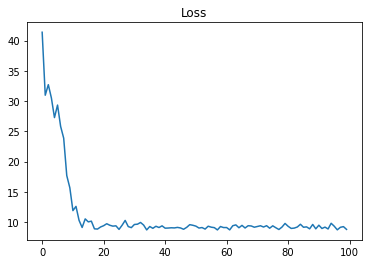

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from matplotlib import pyplot as plt
from made import MADE

random.seed(123)
torch.manual_seed(123)

# NN used for p(x | y)
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32, out_size=1, t="normal", out_non_linear=None):
        super().__init__()
        self.t = t
        self.out_non_linear = out_non_linear
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        if t == "normal":
            self.loc_layer = nn.Linear(hidden, out_size)
            self.std_layer = nn.Linear(hidden, out_size)
            self.softplus = nn.Softplus()
        elif t == "bern":
            self.prob_layer = nn.Linear(hidden, out_size)
        elif t == "mlp":
            self.out_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        for i in range(len(x_list)):
            if x_list[i].dim() == 0:
                x_list[i] = torch.unsqueeze(x_list[i], dim=0)
        input_x = torch.cat(x_list)
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        if self.t == "normal":
            return self.loc_layer(hid), self.softplus(self.std_layer(hid))
        elif self.t == "bern":
            return torch.sigmoid(self.prob_layer(hid))
        else:
            if self.out_non_linear == "tanh":
                return torch.tanh(self.out_layer(hid))
            else:
                return self.out_layer(hid)
        
class simpleRNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=32, max_l=5, max_t=3):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size + max_l + max_t, hidden_size=hidden_size, nonlinearity='relu',
                          batch_first=True, num_layers=1)
        self.h_0 = nn.Parameter(torch.zeros((1, 1, hidden_size)))
        self.out_loc = nn.Linear(hidden_size, 1)
        self.out_std = nn.Linear(hidden_size, 1)
        self.max_l = max_l # max time steps
        self.max_t = max_t # type of random variables, ex. y1 y2 next_x
        self.softplus = nn.Softplus()
        
    def forward(self, x, obs, l, t):
        """
        x: x0
        obs: R
        l: length
        t: type, y1, y2 or next_x
        """
        length = l * 3
        input_x = x.repeat((int(length), 1))
        input_obs = obs.repeat((int(length), 1))
        input_l = []
        input_t = []
        
        for n in range(int(l)):
            
            for i in range(int(t)):
                input_l.append(n)
                input_t.append(i)
        input_l = F.one_hot(torch.tensor(input_l), self.max_l) 
        input_t = F.one_hot(torch.tensor(input_t), self.max_t) 
        
        input_ = torch.unsqueeze(torch.cat([input_x, input_obs, input_l, input_t], -1), 0)
        
        # the input is [x, obs, onehot(l), onehot(t)]
        rnn_output, _ = self.rnn(input_, self.h_0)
        rnn_output = torch.squeeze(rnn_output, 0)
        out_loc = self.out_loc(F.relu(rnn_output))
        out_std = self.softplus(self.out_std(F.relu(rnn_output)))
        # the first outputs are y_1_1, y_2_1, next_x_1; y_1_2, y_2_2, next_x_2
        return torch.squeeze(out_loc, 1), torch.squeeze(out_std, 1) # shape l * t

class Experiment(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = 3
        self.max_rec = 5
        
        # for guide_0
        self.h_a_nn_0 = simpleNN(input_size=self.hidden_size, t="bern")
        self.h_b_nn_0 = simpleNN(input_size=self.hidden_size)
        self.h_encoder_0 = simpleNN(input_size=1 + self.hidden_size, out_size=self.hidden_size, t="mlp")
        self.h0_0 = nn.Parameter(torch.zeros(self.hidden_size))
        
        
        # for guide_1
        self.h_a_nn_1 = simpleNN(input_size=1 + self.hidden_size, t="bern")
        self.h_b_nn_1 = simpleNN(input_size=1 + self.hidden_size)
        self.h_encoder_1 = simpleNN(input_size=1 + self.hidden_size, out_size=self.hidden_size, t="mlp")
        self.h0_1 = nn.Parameter(torch.zeros(self.hidden_size))
        
        # for guide_2
        self.h_a_nn_2 = simpleNN(input_size=1 + self.hidden_size, t="bern")
        self.h_b_nn_2 = simpleNN(input_size=2 + self.hidden_size)
        self.h_encoder_2 = simpleNN(input_size=2 + self.hidden_size, out_size=self.hidden_size, t="mlp")
        self.h0_2 = nn.Parameter(torch.zeros(self.hidden_size))
        
        # for guide_made_0
        self.hidden_size_made_0 = 3
        self.made_in_dim_0_1 = 1 + self.hidden_size_made_0
        self.num_var_0_1 = 1
        self.made_out_dim_0_1 = self.made_in_dim_0_1 * self.num_var_0_1
        self.made_hidden_0_1 = [32, 32]
        self.made_0_1 = MADE(self.made_in_dim_0_1, self.made_hidden_0_1, self.made_out_dim_0_1, num_masks=1, natural_ordering=True)
        self.made_map_a_0 = nn.Linear(self.made_out_dim_0_1, 1)
    
        self.made_in_dim_0_2 = 2 + self.hidden_size_made_0
        self.num_var_0_2 = 1
        self.made_out_dim_0_2 = self.made_in_dim_0_2 * self.num_var_0_2
        self.made_hidden_0_2 = [32, 32]
        self.made_0_2 = MADE(self.made_in_dim_0_2, self.made_hidden_0_2, self.made_out_dim_0_2, num_masks=1, natural_ordering=True)
        self.made_map_b_loc_0 = nn.Linear(self.made_out_dim_0_2, 1)
        self.made_map_b_std_0 = nn.Linear(self.made_out_dim_0_2, 1)
        self.h_encoder_made_0 = simpleNN(input_size=2 + self.hidden_size, out_size=self.hidden_size, t="mlp")
        self.h0_made_0 = nn.Parameter(torch.zeros(self.hidden_size_made_0))
        
        self.softplus = nn.Softplus()

    
    def g(self, x):
        return torch.tanh(x) 
    
    def model(self, obs):
        pyro.module("model", self)
        def rec_model(prefix, l):
            a = pyro.sample("a_{}".format(prefix), dist.Bernoulli(0.5))
            if a > 0 or l > self.max_rec:
                b = pyro.sample("b_{}".format(prefix), dist.Normal(0, 1))
                return b
            else:
                c = rec_model(prefix+"c", l + 1)
                d = rec_model(prefix+"d", l + 1)
                return c + d
        sig = torch.tensor(0.5)
        x = rec_model("root", 0)
        pyro.sample("obs", dist.Normal(x, sig), obs=float(obs))
    
    # guide uses simple and individual NN for each random variable
    def guide_0(self, obs):
        pyro.module("model", self)
        def rec_guide(prefix, h, l):
            a_prob = self.h_a_nn_0([h])
            a = pyro.sample("a_{}".format(prefix), dist.Bernoulli(a_prob))
            if a > 0 or l > self.max_rec:
                b_loc, b_std = self.h_b_nn_0([h])
                return pyro.sample("b_{}".format(prefix), dist.Normal(b_loc, b_std))
            else:
                c = rec_guide(prefix+"c", h, l + 1)
                h = self.h_encoder_0([c,h])
                d = rec_guide(prefix+"d", h, l + 1)
                return c + d 
        rec_guide("root", self.h0_0, 0)
                
    
    # guide uses simple and individual NN for each random variable, add obs as dependency
    def guide_1(self, obs):
        pyro.module("model", self)
        def rec_guide(prefix, h, obs, l):
            a_prob = self.h_a_nn_1([h, obs])
            a = pyro.sample("a_{}".format(prefix), dist.Bernoulli(a_prob))
            if a > 0 or l > self.max_rec:
                b_loc, b_std = self.h_b_nn_1([h, obs])
                return pyro.sample("b_{}".format(prefix), dist.Normal(b_loc, b_std))
            else:
                c = rec_guide(prefix+"c", h, obs, l + 1)
                h = self.h_encoder_1([c,h])
                d = rec_guide(prefix+"d", h, obs, l + 1)
                return c + d 
        rec_guide("root", self.h0_1, obs, 0)
        
    # guide uses simple and individual NN for each random variable, more dependency considered
    def guide_2(self, obs):
        pyro.module("model", self)
        def rec_guide(prefix, h, obs, l):
            a_prob = self.h_a_nn_2([h, obs])
            a = pyro.sample("a_{}".format(prefix), dist.Bernoulli(a_prob))
            if a > 0 or l > self.max_rec:
                b_loc, b_std = self.h_b_nn_2([h, obs, a])
                return pyro.sample("b_{}".format(prefix), dist.Normal(b_loc, b_std))
            else:
                c = rec_guide(prefix+"c", h, obs, l + 1)
                h = self.h_encoder_2([c,h,a])
                d = rec_guide(prefix+"d", h, obs, l + 1)
                return c + d 
        rec_guide("root", self.h0_2, obs, 0)
        
    def guide_made_0(self, obs):
        pyro.module("model", self)
        def concat_input_made(x_list):
            for i in range(len(x_list)):
                if x_list[i].dim() == 0:
                    x_list[i] = torch.unsqueeze(x_list[i], dim=0)
            input_x = torch.cat(x_list)
            return input_x
        def rec_guide(prefix, h, obs, l):
            made_1_in = concat_input_made([h, obs])
            made_1_out = self.made_0_1(made_1_in)
            a_prob = torch.sigmoid(self.made_map_a_0(made_1_out))
            a = pyro.sample("a_{}".format(prefix), dist.Bernoulli(a_prob))
            if a > 0 or l > self.max_rec:
                made_2_in = concat_input_made([h, obs, a])
                made_2_out = self.made_0_2(made_2_in)
                b_loc = self.made_map_b_loc_0(made_2_out)
                b_std = self.softplus(self.made_map_b_std_0(made_2_out))
                return pyro.sample("b_{}".format(prefix), dist.Normal(b_loc, b_std))
            else:
                c = rec_guide(prefix+"c", h, obs, l + 1)
                h = self.h_encoder_made_0([c,h,a])
                d = rec_guide(prefix+"d", h, obs, l + 1)
                return c + d 
        rec_guide("root", self.h0_made_0, obs, 0)
    
def generate_data():
    # the actual data generation has three latent variables (y_1, y_2, y_3)
    x0 = random.random() / 50
    base_std = 0.356
    def f(x0):
        a = dist.Bernoulli(x0).sample()
        if a > 0:
            noise_mean = random.random() / 5 
            if random.random() < 0.5:
                noise_mean *= -1
            noise_std = random.random() / 5
            return dist.Normal(2 * x0 + noise_mean, base_std + noise_std).sample()
        else:
            s = 0
            for _ in range(2):
                s += f(max(x0 + random.random() / 10, 0.75))
            return s
        
    return f(x0)
    
data = []
num_data = 100
for _ in range(num_data):
    data.append(generate_data())

print(data)
experiment = Experiment()
adam_params = {"lr": 0.001, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)
guide = experiment.guide_made_0 # guide_1

svi = SVI(experiment.model, guide, optimizer, loss=Trace_ELBO())

n_steps = 100
log_interval = 10
# do gradient steps
loss = 0
loss_track = []
for step in range(1, n_steps + 1):
    imme_loss = 0
    
    for obs in data:
        imme_loss += svi.step(obs) / num_data
        
    loss_track.append(imme_loss)
    loss += imme_loss / log_interval
    
    if step % log_interval == 0:
        print("[Step {}/{}] Immediate Loss: {} Accumlated Loss: {}".format(step, n_steps, imme_loss, loss))
        loss = 0
    
plt.plot(loss_track)
plt.title("Loss")
plt.show()
    

results:

In [2]:
# guide_0
[Step 10/200] Immediate Loss: 19.031159826517108 Accumlated Loss: 30.669728822827345
[Step 20/200] Immediate Loss: 16.54116699755191 Accumlated Loss: 16.42493181198835
[Step 30/200] Immediate Loss: 15.830906611680986 Accumlated Loss: 15.341987950056792
[Step 40/200] Immediate Loss: 14.625833902955055 Accumlated Loss: 15.328452881455421
[Step 50/200] Immediate Loss: 15.429139192998413 Accumlated Loss: 15.12139590618014
[Step 60/200] Immediate Loss: 16.700843995809553 Accumlated Loss: 15.193378344476224
[Step 70/200] Immediate Loss: 13.782704436480998 Accumlated Loss: 14.926948586285116
[Step 80/200] Immediate Loss: 13.849593170583253 Accumlated Loss: 14.773630363225937
[Step 90/200] Immediate Loss: 14.682365895658728 Accumlated Loss: 14.936238646164536
[Step 100/200] Immediate Loss: 14.949490445554256 Accumlated Loss: 15.427314028546215
[Step 110/200] Immediate Loss: 15.533587679564953 Accumlated Loss: 15.366392598420385
[Step 120/200] Immediate Loss: 15.174833083748815 Accumlated Loss: 15.251150453075768
[Step 130/200] Immediate Loss: 15.296379088461395 Accumlated Loss: 15.222727478057147
[Step 140/200] Immediate Loss: 14.548529184162614 Accumlated Loss: 15.24323720142245
[Step 150/200] Immediate Loss: 15.327036719620224 Accumlated Loss: 15.089846912264827
[Step 160/200] Immediate Loss: 15.66180207520723 Accumlated Loss: 15.366233869403601
[Step 170/200] Immediate Loss: 15.747280451953404 Accumlated Loss: 14.878797188669443
[Step 180/200] Immediate Loss: 14.456126456558705 Accumlated Loss: 14.763787083625793
[Step 190/200] Immediate Loss: 14.843872060179715 Accumlated Loss: 14.933787340179087
[Step 200/200] Immediate Loss: 15.440625265836713 Accumlated Loss: 15.287833866387603

SyntaxError: invalid syntax (<ipython-input-2-cf15846e9d35>, line 2)

In [ ]:
# guide_1
[Step 10/100] Immediate Loss: 17.930261366367343 Accumlated Loss: 27.829307303488253
[Step 20/100] Immediate Loss: 9.592198074162006 Accumlated Loss: 12.552848016187548
[Step 30/100] Immediate Loss: 9.336000512987372 Accumlated Loss: 9.432053346917034
[Step 40/100] Immediate Loss: 8.680979787409306 Accumlated Loss: 9.163381985932588
[Step 50/100] Immediate Loss: 9.146411037594085 Accumlated Loss: 8.818429456993936
[Step 60/100] Immediate Loss: 8.943090667575602 Accumlated Loss: 9.075083977945148
[Step 70/100] Immediate Loss: 8.938816332668068 Accumlated Loss: 8.664682637892664
[Step 80/100] Immediate Loss: 8.656451758295297 Accumlated Loss: 8.717697938293217
[Step 90/100] Immediate Loss: 9.12393444098532 Accumlated Loss: 8.998925273619593
[Step 100/100] Immediate Loss: 8.29359666161239 Accumlated Loss: 8.46837840466201

In [ ]:
# guide_2
[Step 10/100] Immediate Loss: 11.012404969632627 Accumlated Loss: 20.942087798953054
[Step 20/100] Immediate Loss: 8.874061445668339 Accumlated Loss: 9.659853560857476
[Step 30/100] Immediate Loss: 9.305319509208205 Accumlated Loss: 8.925286741890012
[Step 40/100] Immediate Loss: 8.64788700006902 Accumlated Loss: 8.818340191334485
[Step 50/100] Immediate Loss: 8.317036350667474 Accumlated Loss: 8.81623889724165
[Step 60/100] Immediate Loss: 8.895614063516259 Accumlated Loss: 8.728870033808054
[Step 70/100] Immediate Loss: 8.995070771798492 Accumlated Loss: 8.337308281101286
[Step 80/100] Immediate Loss: 7.560207392536105 Accumlated Loss: 9.192471126087941
[Step 90/100] Immediate Loss: 8.08053003266454 Accumlated Loss: 8.266035702221098
[Step 100/100] Immediate Loss: 8.43317556051537 Accumlated Loss: 8.17740331849642

In [ ]:
# guide_made_0
[Step 10/100] Immediate Loss: 15.65785191923381 Accumlated Loss: 27.521529941409828
[Step 20/100] Immediate Loss: 9.181662517264487 Accumlated Loss: 10.142460460945964
[Step 30/100] Immediate Loss: 9.073848144486544 Accumlated Loss: 9.41119017122686
[Step 40/100] Immediate Loss: 9.367795079164203 Accumlated Loss: 9.333177496946416
[Step 50/100] Immediate Loss: 9.464715682566162 Accumlated Loss: 9.114056323527358
[Step 60/100] Immediate Loss: 9.084946442395449 Accumlated Loss: 9.0807487567747
[Step 70/100] Immediate Loss: 9.141939090248197 Accumlated Loss: 9.209436322024091
[Step 80/100] Immediate Loss: 9.76587741822936 Accumlated Loss: 9.230823772877457
[Step 90/100] Immediate Loss: 8.874032034681875 Accumlated Loss: 9.172223159402929
[Step 100/100] Immediate Loss: 8.782549491748213 Accumlated Loss: 9.1371221883737